In [8]:

import os
from src import PROJECT_ROOT, DATA_DIR

import pandas as pd

from src.utils.io import load_json


Pair analysis

In [14]:
clusterings = os.path.join(PROJECT_ROOT, 'result', 'ICLR', '2024', '20250606_1645', 'clusters.csv')
df = pd.read_csv(clusterings)
clusterings = {}
for _, row in df.iterrows():
    method = row['method']
    clustering = []

    for session_col in df.columns[1:]:  # skip 'method' column
        cell = row[session_col]
        if pd.isna(cell):
            continue
        node_list = str(cell).split(',')
        node_list = [node.strip() for node in node_list if node.strip()]
        clustering.append(node_list)

    clusterings[method] = clustering


In [15]:
clusterings

{'Baseline': [['agPpmEgf8C', 'xuY33XhEGR', 'zMPHKOmQNb'],
  ['9JQtrumvg8', 'jNR6s6OSBT', 'sFyTZEqmUY'],
  ['6PmJoRfdaK', 'KUNzEQMWU7', 'uNrFpDPMyo'],
  ['gFR4QwK53h', 'pOoKI3ouv1'],
  ['VtmBAGCN7o', 'ekeyCgeRfC', 'hSyW5go0v8'],
  ['2dnO3LLiJ1', 'Ad87VjRqUw', 'sllU8vvsFF'],
  ['WNkW0cOwiz', 'WNzy9bRDvG', 'gU58d5QeGv'],
  ['HSKaGOi7Ar', 'aN4Jf6Cx69'],
  ['LzPWWPAdY4', 'bNt7oajl2a', 'osoWxY8q2E'],
  ['NSVtmmzeRB', 'P15CHILQlg', 'EanCFCwAjM'],
  ['L0r0GphlIL', 'TpD2aG1h0D', 'cc8h3I3V4E'],
  ['AhizIPytk4', 'yV6fD7LYkF'],
  ['VTF8yNQM66', 'w4abltTZ2f'],
  ['dLrhRIMVmB', 'g7ohDlTITL', 'oO6FsMyDBt'],
  ['LjivA1SLZ6', 'c5pwL0Soay', 'o2IEmeLL9r'],
  ['Ouj6p4ca60', 'nHESwXvxWK'],
  ['ANvmVS2Yr0', 'Zsfiqpft6K', 'tUtGjQEDd4'],
  ['hTEGyKf0dZ', 'hnrB5YHoYu', 'jr03SfWsBS'],
  ['T7YV5UZKBc', 'bTMMNT7IdW', 'tqh1zdXIra'],
  ['5Ca9sSzuDp', 'Yen1lGns2o'],
  ['h922Qhkmx1', 'oTRwljRgiv', 'pzElnMrgSD'],
  ['IGzaH538fz', 'KS8mIvetg2', 'aIok3ZD9to'],
  ['Fk5IzauJ7F', 'HhfcNgQn6p', 'PdaPky8MUn'],
  ['9Cu8MRmhq2

In [16]:
from src import Graph

emb = os.path.join(DATA_DIR, 'emb', 'ICLR', '2024', '20250602_1929', 'emb.json')
emb = load_json(emb)
graph = Graph(emb, 0) # don't use k here

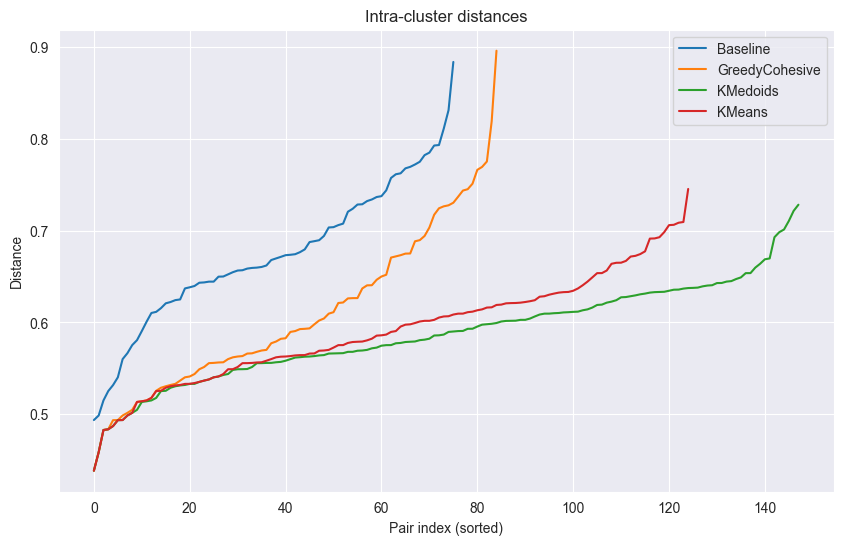

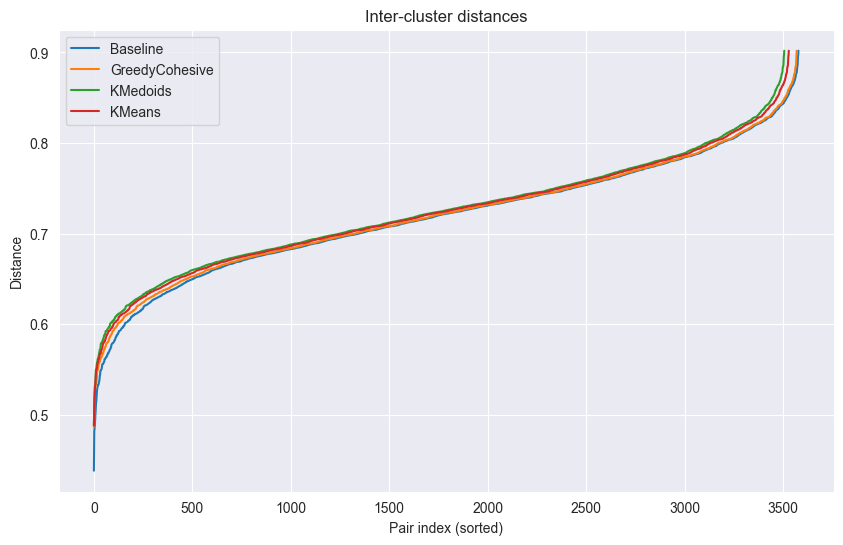

In [17]:
from src.eval.plot.cluster_dist import plot_cluster_distances

# Plot 1: Same cluster
plot_cluster_distances(clusterings, graph, same_cluster=True, title='Intra-cluster distances')

# Plot 2: Different cluster
plot_cluster_distances(clusterings, graph, same_cluster=False, title='Inter-cluster distances')

## Plotting:

In [29]:
eval_path = os.path.join(PROJECT_ROOT, 'result', 'NeurIPS', '2024', '20250602_2158', 'eval.csv')
df = pd.read_csv(eval_path)

In [32]:
import plotly.express as px

# --- Metric groups ---
intracluster_metrics = ['avg_compactness', 'avg_diameter', 'max_diameter', 'worst_avg_spread']
objective_metrics = ['k-means', 'k-medoids']

# --- Plot 1: Intra-cluster Metrics ---
df_intracluster = df.melt(id_vars='model', value_vars=intracluster_metrics,
                          var_name='metric', value_name='value')

fig1 = px.bar(
    df_intracluster,
    x='metric',
    y='value',
    color='model',
    barmode='group',
    title="Intra-cluster Metrics Across Clustering Methods"
)
fig1.update_layout(template='plotly_dark')
fig1.show()

# --- Plot 2: Objective Scores ---
df_objectives = df.melt(id_vars='model', value_vars=objective_metrics,
                        var_name='metric', value_name='value')

fig2 = px.bar(
    df_objectives,
    x='metric',
    y='value',
    color='model',
    barmode='group',
    title="Objective Scores (k-means / k-medoids)"
)
fig2.update_layout(template='plotly_dark')
fig2.show()


In [3]:
iclr21 = os.path.join(PROJECT_ROOT, 'result', 'ICLR', '2021', '20250606_1652', 'eval.csv')
df21 = pd.read_csv(iclr21)
iclr22 = os.path.join(PROJECT_ROOT, 'result', 'ICLR', '2022', '20250606_1651', 'eval.csv')
df22 = pd.read_csv(iclr22)
iclr23 = os.path.join(PROJECT_ROOT, 'result', 'ICLR', '2023', '20250606_1649', 'eval.csv')
df23 = pd.read_csv(iclr23)
iclr24 = os.path.join(PROJECT_ROOT, 'result', 'ICLR', '2024', '20250606_1645', 'eval.csv')
df24 = pd.read_csv(iclr24)

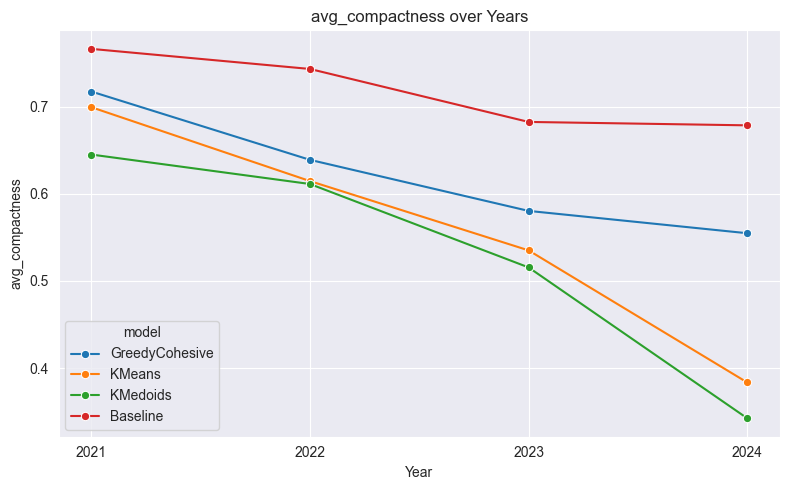

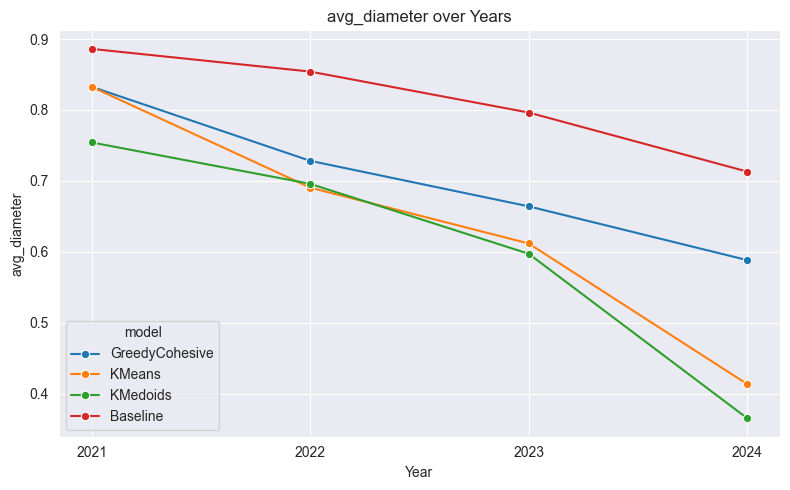

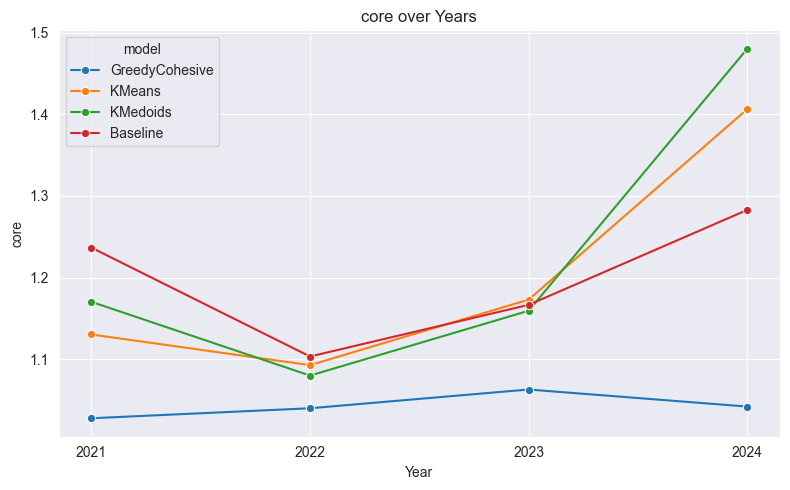

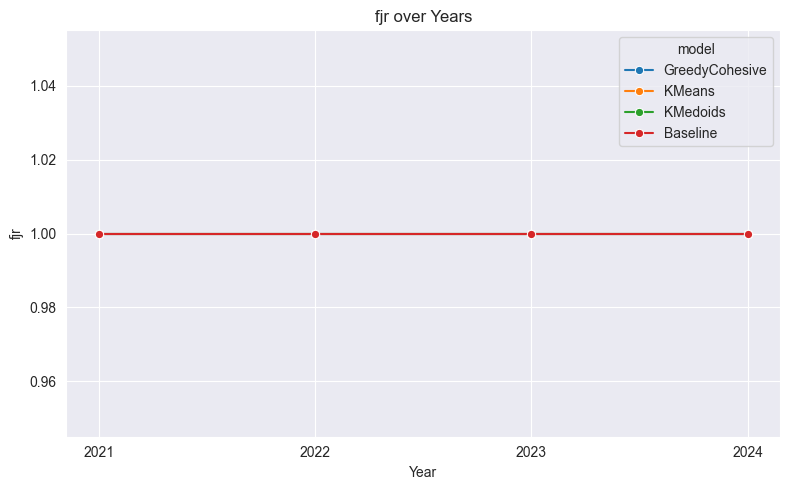

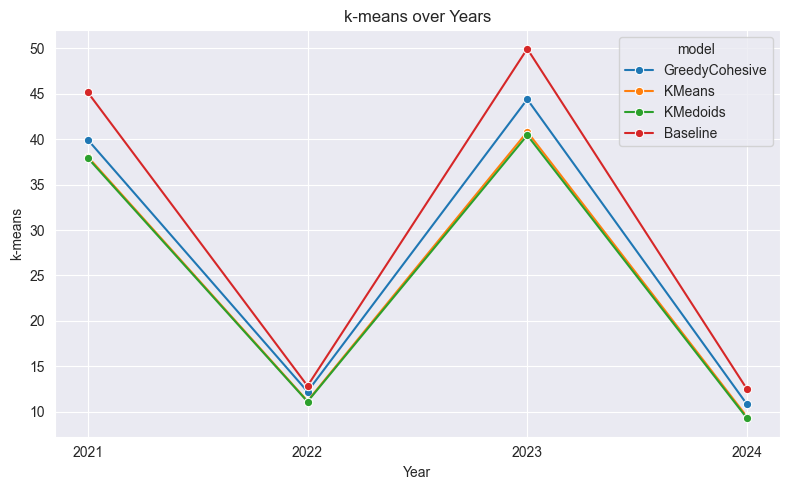

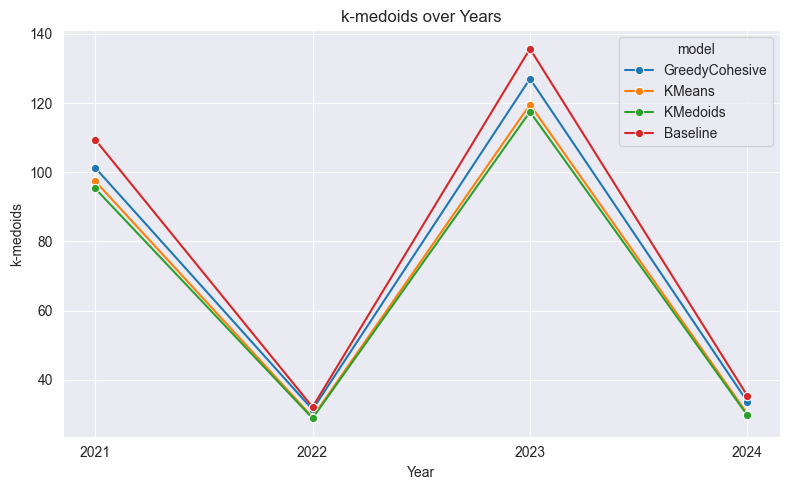

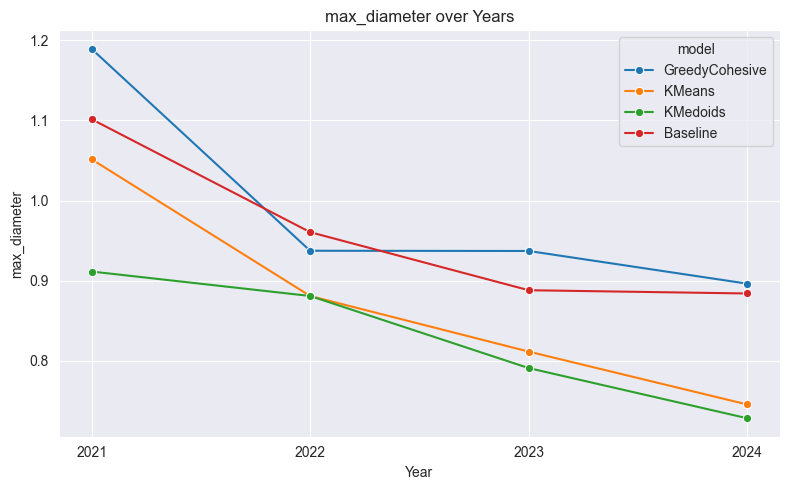

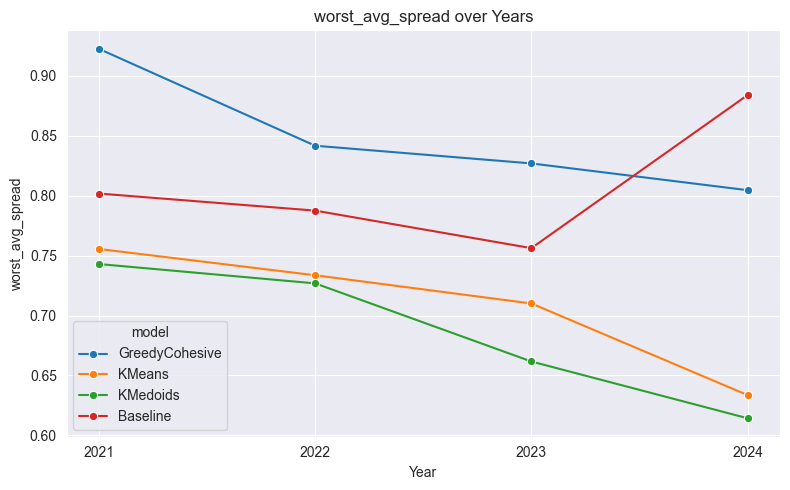

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have these 4 DataFrames loaded:
# df21, df22, df23, df24

# Add year to each dataframe
df21["year"] = 2021
df22["year"] = 2022
df23["year"] = 2023
df24["year"] = 2024

# Combine all years into one dataframe
df_all = pd.concat([df21, df22, df23, df24], ignore_index=True)

# Melt the dataframe for easier plotting
df_long = df_all.melt(id_vars=["model", "year"], var_name="metric", value_name="value")

# Plot each metric separately
metrics = df_long["metric"].unique()
for metric in metrics:
    plt.figure(figsize=(8, 5))
    subset = df_long[df_long["metric"] == metric]
    sns.lineplot(data=subset, x="year", y="value", hue="model", marker="o")
    plt.title(f"{metric} over Years")
    plt.xlabel("Year")
    plt.ylabel(metric)
    plt.grid(True)
    plt.xticks([2021, 2022, 2023, 2024])
    plt.tight_layout()
    plt.show()
